# **Flair classification using LSTMs**

In this notebook, I attempted to enhance the classification accuracy that was achieved with the Logistic regression model using Long short-term memory networks. In order to evaluate the LSTMs performance different models were considered both with pretrained embeddings and a trainable embedding layer.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

import itertools
import datetime

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model, Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv1D, SpatialDropout1D, MaxPooling1D
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

### **Word Embeddings**

Three types of pre-trained embeddings are downloaded into this notebook.

1.   Google's 300 dimension word2vec embeddings
2.   300 dimension Fasttext embeddings trained on wikipedia corpus
3.   100 dimension GLoVe embeddings trained on Twitter data


In [0]:
!kaggle datasets download -d bertcarremans/glovetwitter27b100dtxt

glovetwitter27b100dtxt.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

--2020-04-14 03:15:01--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4a8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  8.94MB/s    in 75s     

2020-04-14 03:16:17 (8.72 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [0]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-04-16 07:26:24--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.4.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.4.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  97.5MB/s    in 17s     

2020-04-16 07:26:41 (94.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
!unzip /content/glovetwitter27b100dtxt.zip

Archive:  /content/glovetwitter27b100dtxt.zip
replace glove.twitter.27B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
!gunzip /content/GoogleNews-vectors-negative300.bin.gz

In [0]:
!unzip /content/wiki-news-300d-1M.vec.zip

Archive:  /content/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


Loading the dataset

In [0]:
DATA_PATH = '/content/drive/My Drive/Reddit_dataset/dataset_final.csv'

dataset = pd.read_csv(DATA_PATH)
dataset = dataset.sample(frac=1.).reset_index(drop=True)
dataset.head()

,Unnamed: 0,created_utc,url,num_comments,selftext,title,over_18,link_flair_text,id,permalink
0,4311,1583778439,https://theprint.in/india/sudarshan-news-top-e...,4,NaN,"Sudarshan News top editor does it again, now c...",False,Politics,ffz7u7,/r/india/comments/ffz7u7/sudarshan_news_top_ed...
1,13703,1583236131,https://www.indialegallive.com/top-news-of-the...,1,NaN,Coronavirus outbreak: Delhi HC asks Centre to ...,False,Non-Political,fctfli,/r/india/comments/fctfli/coronavirus_outbreak_...
2,1218,1581498906,https://www.easternmirrornagaland.com/indo-nag...,0,NaN,Indo-Naga talks: Final touches in process—Rio,False,Politics,f2okxi,/r/india/comments/f2okxi/indonaga_talks_final_...
3,22966,1552106737,https://www.truescoopnews.com/newsdetail/Rajiv...,2,NaN,Gold worth Rs. 90 Lakh seized at Hydrabad airport,False,Policy/Economy,ayzroh,/r/india/comments/ayzroh/gold_worth_rs_90_lakh...
4,9714,1585233157,https://youtu.be/w0k-gmZKMEs,0,NaN,"Watch ""'Lockdown alone will not extinguish COV...",False,Coronavirus,fpchfy,/r/india/comments/fpchfy/watch_lockdown_alone_...


### **Cleaning the data**

Removing stopwords, puntuations, urls and ensuring the text is single spaced. In addition to this, the training data comprises of the post's title and body text. This was done as the body text can provide some information but majority of cases do not have text in the body.

In [0]:
invalid_inputs =  ['nan', '[deleted]', '[removed]']
stop = stopwords.words('english') + ['http', 'https']
print(punctuation)

def clean_text(text):
  text = re.sub('http[s]?://\S+', '', text)
  text = text.translate(str.maketrans('', '', punctuation))
  text = text.lower().strip()
  text = ' '.join([i if i not in stop and i.isalpha() else '' for i in text.lower().split()])
  text = re.sub(r"\s{2,}", " ", text)
  return text

dataset['selftext'] = dataset['selftext'].astype(str)
dataset['title'] = dataset['title'].astype(str)
for invalid_input in invalid_inputs:
  print(invalid_input, len(dataset[dataset['selftext'] == invalid_input]))
dataset['selftext'] = dataset['selftext'].apply(lambda val: '' if val in invalid_inputs else val)
for invalid_input in invalid_inputs:
  print(invalid_input, len(dataset[dataset['selftext'] == invalid_input]))
dataset['title'] = dataset['title'] + ' ' + dataset['selftext']
dataset['title'] = dataset['title'].apply(lambda text: clean_text(text))
dataset.head()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
nan 24483
[deleted] 149
[removed] 4327
nan 0
[deleted] 0
[removed] 0


,Unnamed: 0,created_utc,url,num_comments,selftext,title,over_18,link_flair_text,id,permalink
0,4311,1583778439,https://theprint.in/india/sudarshan-news-top-e...,4,,sudarshan news top editor calls economic boyco...,False,Politics,ffz7u7,/r/india/comments/ffz7u7/sudarshan_news_top_ed...
1,13703,1583236131,https://www.indialegallive.com/top-news-of-the...,1,,coronavirus outbreak delhi hc asks centre subm...,False,Non-Political,fctfli,/r/india/comments/fctfli/coronavirus_outbreak_...
2,1218,1581498906,https://www.easternmirrornagaland.com/indo-nag...,0,,indonaga talks final touches,False,Politics,f2okxi,/r/india/comments/f2okxi/indonaga_talks_final_...
3,22966,1552106737,https://www.truescoopnews.com/newsdetail/Rajiv...,2,,gold worth rs lakh seized hydrabad airport,False,Policy/Economy,ayzroh,/r/india/comments/ayzroh/gold_worth_rs_90_lakh...
4,9714,1585233157,https://youtu.be/w0k-gmZKMEs,0,,watch lockdown alone extinguish lists steps fi...,False,Coronavirus,fpchfy,/r/india/comments/fpchfy/watch_lockdown_alone_...


In [0]:
print(dataset['title'].tolist()[4])

psyops insight yuri bezmenov view stupid psyops pakistanis played us stupidly fell including nyt article posting link yt video showcases provides good deal insight playing long game spycraft liberals rightwingers warmongers peace lovers neutral people part system kind people explained cause consequence video sit back enjoy major part interview covers india please remove without watching thanks view stupid psyops pakistanis played us stupidly fell including nyt article posting link yt video showcases provides good deal insight playing long game spycraft liberals rightwingers warmongers peace lovers neutral people part system kind people explained cause consequence video sit back enjoy major part interview covers india please remove without watching thanks


Setting up the embedding dimension for the LSTM model with a trainable embedding layer. In addition to that, this code segment also tokenizes the words in the dataset.

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(dataset['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45761 unique tokens.


### **Loading word embeddings**

This utility functions loads the GLoVe, word2vec and fasttext embeddings from their respective files. It creates an embedding matrix of the respective dimension and returns this matrix. It also computes the total number of common words between the dataset corpus and the pre-trained embeddings. 

In [0]:
def loadEmbeddingMatrix(typeToLoad):
  if typeToLoad == "glove":
    EMBEDDING_FILE="/content/glove.twitter.27B.100d.txt"
    embed_size = 100
  elif typeToLoad == "word2vec":
    word2vecDict = KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True)
    embed_size = 300
  elif typeToLoad == "fasttext":
    EMBEDDING_FILE="/content/wiki-news-300d-1M.vec"
    embed_size = 300

  if typeToLoad == "glove" or typeToLoad == "fasttext":
    embeddings_index = dict()
    f = open(EMBEDDING_FILE)
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    f.close()
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
  else:
    embeddings_index = dict()
    for word in word2vecDict.wv.vocab:
      embeddings_index[word] = word2vecDict.word_vec(word)
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
  embedding_matrix = np.zeros((len(word_index), embed_size))

  embeddedCount = 0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")
        
  del(embeddings_index)
        
  return embedding_matrix

In [0]:
glove_embedding_matrix = loadEmbeddingMatrix("glove")

Loaded 1193514 word vectors.
total embedded: 30888 common words


In [0]:
word2vec_embedding_matrix = loadEmbeddingMatrix("word2vec")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Loaded 3000000 word vectors.
total embedded: 28724 common words


In [0]:
fasttext_embedding_matrix = loadEmbeddingMatrix("fasttext")

Loaded 999995 word vectors.
total embedded: 30499 common words


Convert the text in the dataset to sequences and pad these sequences as well. In order to allow for predictions, this tokenizer is saved in a pickle file.

In [0]:
X = tokenizer.texts_to_sequences(dataset['title'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
print(X)

Shape of data tensor: (36000, 250)
[[   0    0    0 ...  192 3668 3084]
 [   0    0    0 ...  211 1942 1455]
 [   0    0    0 ... 1477  983 6929]
 ...
 [   0    0    0 ...  826  932  836]
 [   0    0    0 ...  268 3852  268]
 [   0    0    0 ... 4994  629 3175]]


In [0]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
Y = pd.get_dummies(dataset['link_flair_text']).values
print(dataset['link_flair_text'])
print('Shape of label tensor:', Y.shape)
print(Y)

0                  Politics
1             Non-Political
2                  Politics
3            Policy/Economy
4               Coronavirus
                ...        
35995    Science/Technology
35996           Coronavirus
35997              Politics
35998              AskIndia
35999    Science/Technology
Name: link_flair_text, Length: 36000, dtype: object
Shape of label tensor: (36000, 6)
[[0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 ...
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]]


Split the data into train, test and validation. Stratify is used as an attempt to ensure that the split data does not have class imbalance.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.10, stratify=Y_train)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape,Y_test.shape)

(25920, 250) (25920, 6)
(2880, 250) (2880, 6)
(7200, 250) (7200, 6)


Compiling both LSTM models - with pre-trained embeddings and with a trainable embedding layer.

In [0]:
def compile_lstm_model(embedding_matrix):
  model = Sequential()
  model.add(Embedding(len(word_index), embedding_matrix.shape[1], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  model.add(Dropout(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.4))
  model.add(Dense(6, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
  model.summary()

  return model

In [0]:
def compile_lstm_nopre_model():
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
  model.add(Dropout(0.5))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.4))
  model.add(Dense(6, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
  model.summary()

  return model

In [0]:
lstm_glove_model = compile_lstm_model(glove_embedding_matrix)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          4576200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 4,657,206
Trainable params: 81,006
Non-trainable params: 4,576,200
_________________________________________________________________


In [0]:
lstm_no_pre = compile_lstm_nopre_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_word2vec_model = compile_lstm_model(word2vec_embedding_matrix)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 300)          13728300  
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 13,889,306
Trainable params: 161,006
Non-trainable params: 13,728,300
_________________________________________________________________


In [0]:
lstm_fasttext_model = compile_lstm_model(fasttext_embedding_matrix)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          13728300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 13,889,306
Trainable params: 161,006
Non-trainable params: 13,728,300
_________________________________________________________________


Utility functions to train each model, evaluate the accuracy and loss. In addition to this, it also plots the epoch vs acc and epoch vs loss for each model. Each model also has two callbacks:

1.   Early stopping with the patience set as 5
2.   Checkpoint to save weights at the end of each epoch.



In [0]:
epochs = 100
batch_size = 64

def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

def plot_acc(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend()
  plt.show()

def train_test_model(model, embedding_type="", model_type=""):
  checkpoint_path = "/content/drive/My Drive/Reddit_dataset/cp-{epoch:04d}-" + str(embedding_type) + "-" + model_type + ".ckpt"
  cp_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, period=1)
  es_callback = EarlyStopping(patience=5)
  history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[cp_callback, es_callback])
  accr = model.evaluate(X_test, Y_test)
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  plot_acc(history)
  plot_loss(history)

The LSTM with no pre-trained embeddings seems to be start overfitting almost immediately. As a result, the training is quit due to the Early Stopping callback.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25920 samples, validate on 2880 samples
Epoch 1/20
25920/25920 [==============================] - 627s 24ms/step - loss: 1.4415 - accuracy: 0.4430 - val_loss: 1.1812 - val_accuracy: 0.5681

Epoch 00001: saving model to /content/drive/My Drive/Reddit_dataset/cp-0001--.ckpt
Epoch 2/20
25920/25920 [==============================] - 649s 25ms/step - loss: 1.0486 - accuracy: 0.6190 - val_loss: 1.1273 - val_accuracy: 0.5941

Epoch 00002: saving model to /content/drive/My Drive/Reddit_dataset/cp-0002--.ckpt
Epoch 3/20
25920/25920 [==============================] - 658s 25ms/step - loss: 0.8294 - accuracy: 0.7052 - val_loss: 1.1630 - val_accuracy: 0.5944

Epoch 00003: saving model to /content/drive/My Drive/Reddit_dataset/cp-0003--.ckpt
Epoch 4/20
25920/25920 [==============================] - 659s 25ms/step - loss: 0.6715 - accuracy: 0.7652 - val_loss: 1.2414 - val_accuracy: 0.5747

Epoch 00004: saving model to /content/drive/My Drive/Reddit_dataset/cp-0004--.ckpt
Epoch 5/20
25920/25

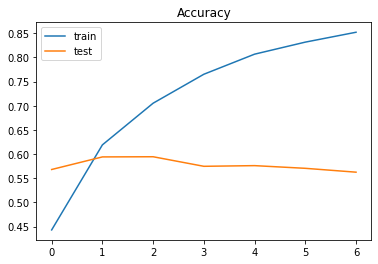

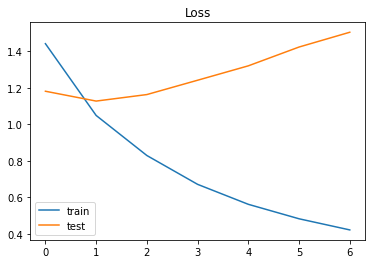

In [0]:
train_test_model(lstm_no_pre)
lstm_no_pre.save('/content/drive/My Drive/Reddit_dataset/lstm_no_pre.h5')

The GLoVe model trains for longer. However, the model is learning too slowly and thus has a bad accuracy on the test set.

Train on 25920 samples, validate on 2880 samples
Epoch 1/20
25920/25920 [==============================] - 606s 23ms/step - loss: 1.7318 - accuracy: 0.2566 - val_loss: 1.6880 - val_accuracy: 0.2979

Epoch 00001: saving model to /content/drive/My Drive/Reddit_dataset/cp-0001-glove-lstm.ckpt
Epoch 2/20
25920/25920 [==============================] - 610s 24ms/step - loss: 1.6911 - accuracy: 0.2919 - val_loss: 1.6786 - val_accuracy: 0.2969

Epoch 00002: saving model to /content/drive/My Drive/Reddit_dataset/cp-0002-glove-lstm.ckpt
Epoch 3/20
25920/25920 [==============================] - 602s 23ms/step - loss: 1.6817 - accuracy: 0.3016 - val_loss: 1.6718 - val_accuracy: 0.3222

Epoch 00003: saving model to /content/drive/My Drive/Reddit_dataset/cp-0003-glove-lstm.ckpt
Epoch 4/20
25920/25920 [==============================] - 599s 23ms/step - loss: 1.6730 - accuracy: 0.3110 - val_loss: 1.6590 - val_accuracy: 0.3295

Epoch 00004: saving model to /content/drive/My Drive/Reddit_dataset/cp-0004

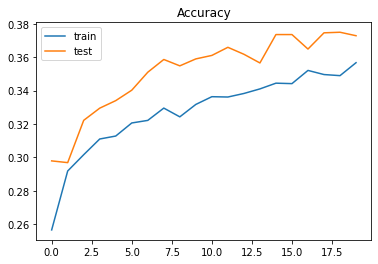

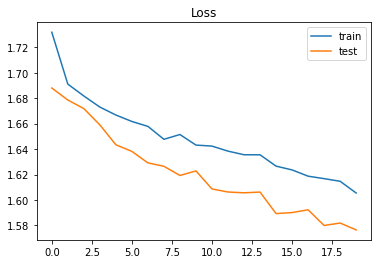

In [0]:
train_test_model(lstm_glove_model, "glove", "lstm")
lstm_glove_model.save('/content/drive/My Drive/Reddit_dataset/lstm_glove_model.h5')

The Fasttext and Word2Vec models performed much better and outperformed both the previous models on baseline training of 20 epochs. As a result I trained each on 100 epochs as the increase in validation accuracy and decrease in validation loss was slow, yet steady. The word2vec model narrowly outperforms the fasttext model with an accuracy of 0.521 vs 0.518 and a loss of 1.278 vs 1.282. This accuracy was lesser than that achieved by the LSTM with no pre-trained embedding. However, that model was significantly overfitting.

Train on 25920 samples, validate on 2880 samples
Epoch 1/100
25920/25920 [==============================] - 189s 7ms/step - loss: 1.7523 - accuracy: 0.2550 - val_loss: 1.7041 - val_accuracy: 0.3028

Epoch 00001: saving model to /content/drive/My Drive/Reddit_dataset/cp-0001-word2vec-lstm.ckpt
Epoch 2/100
25920/25920 [==============================] - 189s 7ms/step - loss: 1.6833 - accuracy: 0.3186 - val_loss: 1.6459 - val_accuracy: 0.3524

Epoch 00002: saving model to /content/drive/My Drive/Reddit_dataset/cp-0002-word2vec-lstm.ckpt
Epoch 3/100
25920/25920 [==============================] - 190s 7ms/step - loss: 1.6246 - accuracy: 0.3500 - val_loss: 1.5897 - val_accuracy: 0.3736

Epoch 00003: saving model to /content/drive/My Drive/Reddit_dataset/cp-0003-word2vec-lstm.ckpt
Epoch 4/100
25920/25920 [==============================] - 187s 7ms/step - loss: 1.6031 - accuracy: 0.3624 - val_loss: 1.5703 - val_accuracy: 0.3840

Epoch 00004: saving model to /content/drive/My Drive/Reddit_datase

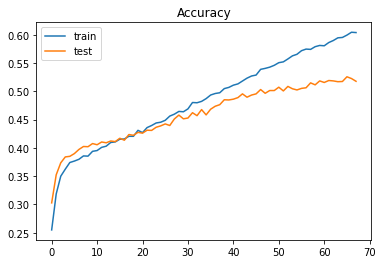

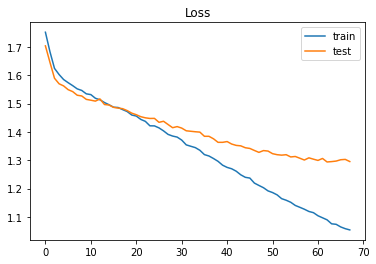

In [0]:
train_test_model(lstm_word2vec_model, "word2vec", "lstm")
lstm_word2vec_model.save('/content/drive/My Drive/Reddit_dataset/lstm_word2vec_model.h5')

Train on 25920 samples, validate on 2880 samples
Epoch 1/100
25920/25920 [==============================] - 209s 8ms/step - loss: 1.7515 - accuracy: 0.2583 - val_loss: 1.6983 - val_accuracy: 0.3184

Epoch 00001: saving model to /content/drive/My Drive/Reddit_dataset/cp-0001-fasttext-lstm.ckpt
Epoch 2/100
25920/25920 [==============================] - 207s 8ms/step - loss: 1.6715 - accuracy: 0.3231 - val_loss: 1.6130 - val_accuracy: 0.3694

Epoch 00002: saving model to /content/drive/My Drive/Reddit_dataset/cp-0002-fasttext-lstm.ckpt
Epoch 3/100
25920/25920 [==============================] - 208s 8ms/step - loss: 1.6174 - accuracy: 0.3547 - val_loss: 1.5790 - val_accuracy: 0.3938

Epoch 00003: saving model to /content/drive/My Drive/Reddit_dataset/cp-0003-fasttext-lstm.ckpt
Epoch 4/100
25920/25920 [==============================] - 209s 8ms/step - loss: 1.5939 - accuracy: 0.3706 - val_loss: 1.5632 - val_accuracy: 0.3920

Epoch 00004: saving model to /content/drive/My Drive/Reddit_datase

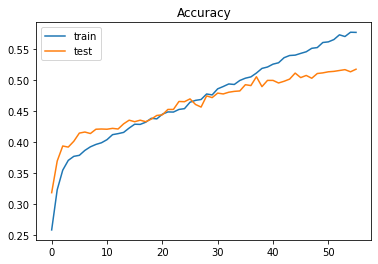

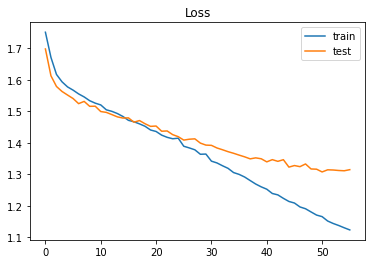

In [0]:
train_test_model(lstm_fasttext_model, "fasttext", "lstm")
lstm_fasttext_model.save('/content/drive/My Drive/Reddit_dataset/lstm_fasttext_model.h5')

### **Inference**

The word2vec performed the best of all the 4 models I had trained. However, these models were outperformed by the logistic regression model trained. Due to this reason, I deployed the logistic regression model with the webapp.